# Sample Lya posterior as a function of nuisance parameters

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Lya likelihood function

In [3]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.7)
zs=data.z

In [4]:
basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label=None
skewers_label=None
undersample_z=1
paramList=["Delta2_p","mF","sigT_Mpc","gamma","kF_Mpc"]
max_arxiv_size=2000
kmax_Mpc=3.0
emu_type='polyGP'
if emu_type=='polyGP':
    emu=gp_emulator.PolyfitGPEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                kmax_Mpc=kmax_Mpc,verbose=True,paramList=paramList,train=True)
elif emu_type=='kGP':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                               undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                               verbose=True,paramList=paramList,train=True)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=False)
else:
    raise ValueError('wrong emulator type '+emu_type)

latin hyper-cube data {'param_space': {'heat_amp': {'ip': 0, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 1, 'min_val': -0.5, 'max_val': 0.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 2, 'min_val': 6.0, 'max_val': 12.0, 'latex': '$z_r$'}}, 'nsamples': 6, 'samples': {'0': [1.125, -0.08333333333333337, 9.5], '1': [1.875, 0.25, 8.5], '2': [0.875, 0.08333333333333326, 10.5], '3': [1.375, -0.25, 6.5], '4': [0.625, 0.41666666666666663, 7.5], '5': [1.625, -0.4166666666666667, 11.5]}}
simulation suite has 6 samples
0 sample has sim params = [1.125, -0.08333333333333337, 9.5]
simulation has 20 redshifts
undersample_z = 1
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_0_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_1_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_2_Ns100_wM0.07.json snapshot does not

In [7]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
#free_parameters=['ln_tau_0','ln_tau_1']
free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0','ln_kF_0']
#free_parameters=['ln_tau_0','ln_T0_0','ln_gamma_0']

In [8]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
setup with 50 walkers
set 50 walkers with 5 dimensions
done setting up sampler


In [9]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -0.794580172414 -1.5 -0.5
ln_tau_1 3.18 2.5 3.8
ln_T0_0 9.39266192877 8.2940496401 10.3089526606
ln_gamma_0 0.336472236621 0.0953101798043 0.69314718056
ln_kF_0 -1.77195684193 -2.99573227355 -0.69314718056


### Run burn-in chains

In [10]:
sampler.like.go_silent()

In [11]:
sampler.run_burn_in(nsteps=200)

start burn-in, will do 200 steps
0 [ 0.50980161  0.508959    0.56808824  0.53952168  0.44440232]
20 [ 0.57611858  0.52120569  0.64349353  0.57434329  0.44930405]
40 [ 0.62140479  0.58252375  0.63954137  0.54434662  0.44889506]
60 [ 0.62901683  0.60322826  0.63085964  0.54718873  0.45030268]
80 [ 0.62976093  0.61989562  0.62990406  0.53807675  0.45010133]
100 [ 0.63357682  0.63354491  0.62689898  0.53576067  0.45075053]
120 [ 0.63274298  0.64274211  0.63059089  0.5151492   0.44993579]
140 [ 0.64362283  0.64275388  0.63106234  0.51205592  0.44769672]
160 [ 0.64337329  0.63916732  0.63293608  0.50844495  0.44704749]
180 [ 0.64384565  0.63508182  0.63230517  0.50238084  0.44696383]
finished burn-in


### Run main chains

In [12]:
sampler.run_chains(nsteps=500)

0 [ 0.640582    0.63410223  0.63564144  0.48467744  0.4461898 ]
20 [ 0.57902405  0.56993251  0.59863097  0.28997936  0.45802295]
40 [ 0.55509775  0.5188652   0.59698947  0.27016979  0.45904628]
60 [ 0.53872846  0.47742063  0.59380397  0.28658164  0.45926305]
80 [ 0.53678487  0.43943232  0.59387441  0.2841023   0.45972685]
100 [ 0.55309343  0.36403427  0.59231588  0.27931345  0.45934194]
120 [ 0.58216489  0.25949968  0.58863355  0.27543338  0.45783857]
140 [ 0.59450271  0.21397804  0.5853703   0.27078088  0.45734155]
160 [ 0.60011678  0.19303003  0.58321023  0.27002126  0.4575114 ]
180 [ 0.60896465  0.16289545  0.58057458  0.26827242  0.45722439]
200 [ 0.60416166  0.17581988  0.5810719   0.27005698  0.45744828]
220 [ 0.6049733   0.16795972  0.58376081  0.26939012  0.45724095]
240 [ 0.61031618  0.15222422  0.58061299  0.26875684  0.45735653]
260 [ 0.60685987  0.15089939  0.57955429  0.26791881  0.45798213]
280 [ 0.60583759  0.15843677  0.57970856  0.26884761  0.45758874]
300 [ 0.60572822

In [13]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.473


### Plot results in cube units (0 < x < 1)

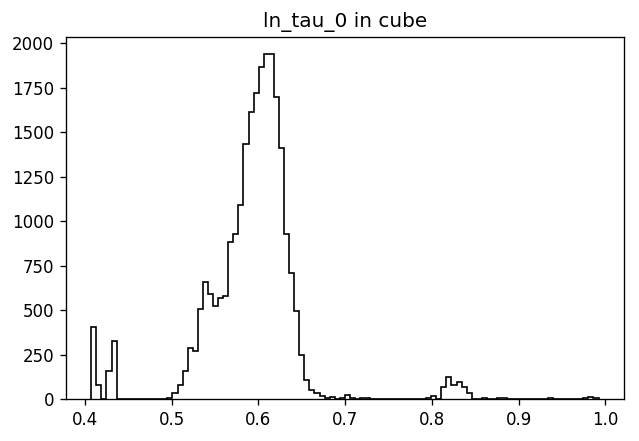

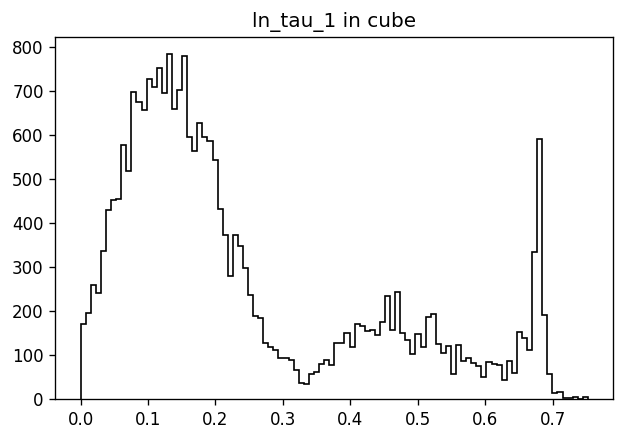

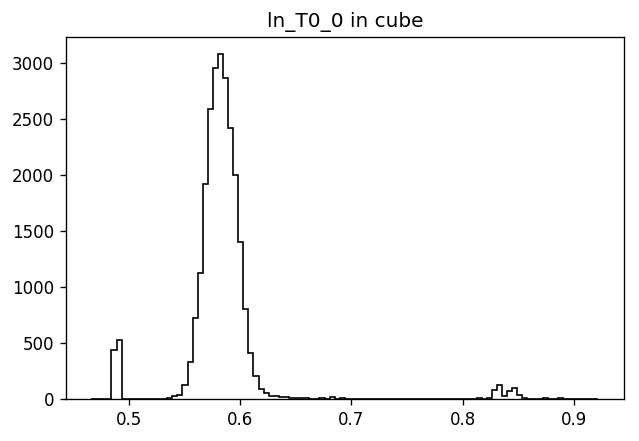

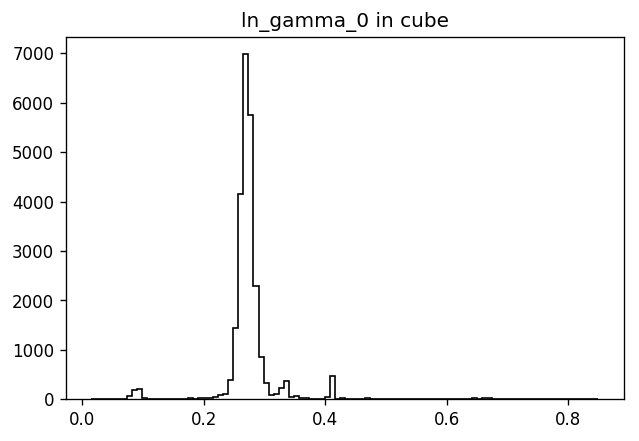

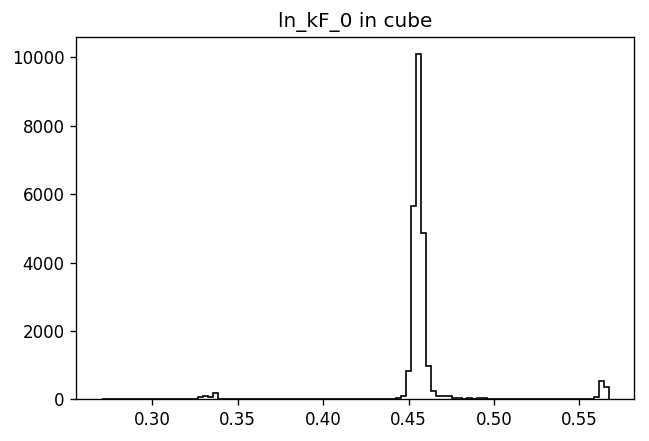

In [14]:
sampler.plot_histograms(cube=True)

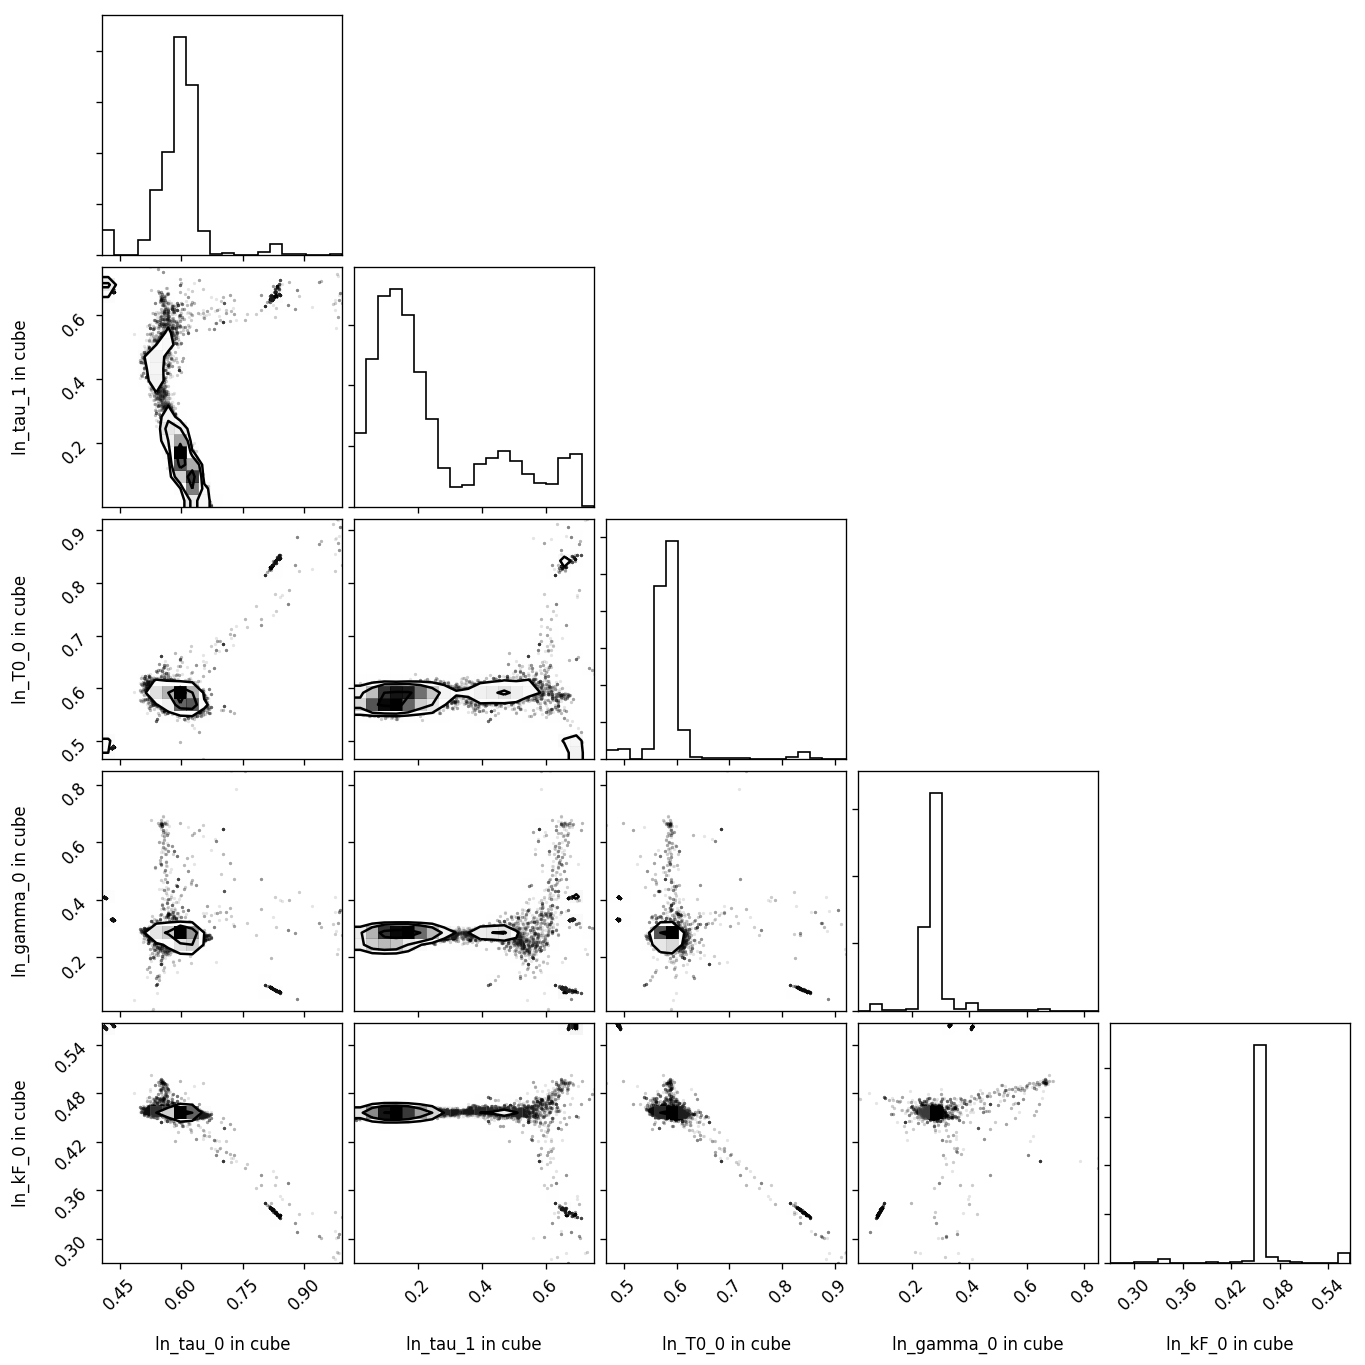

In [15]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

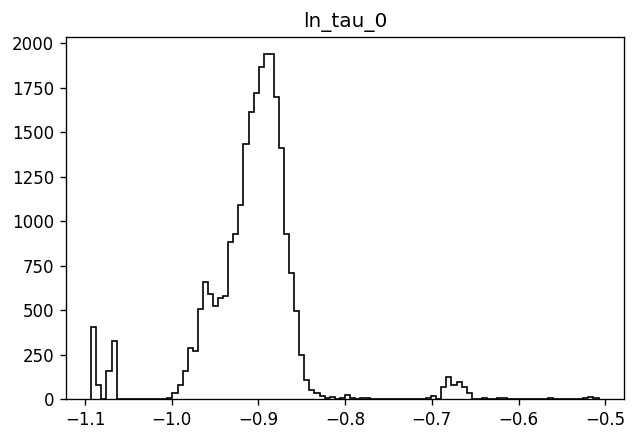

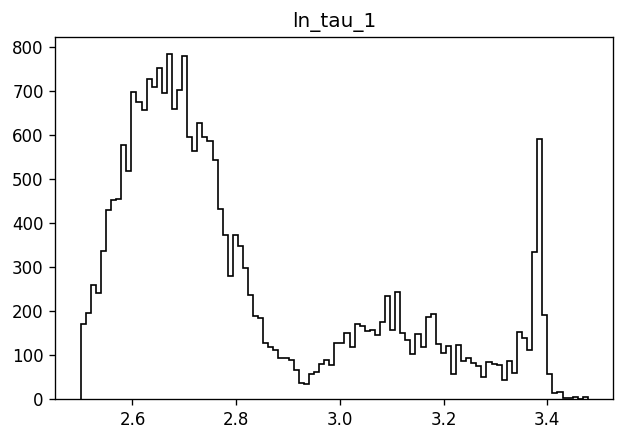

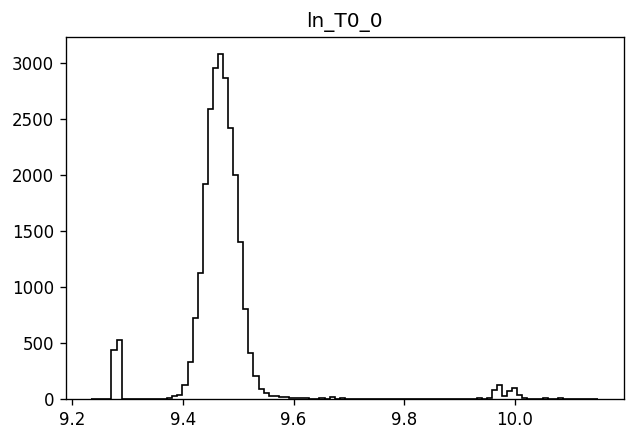

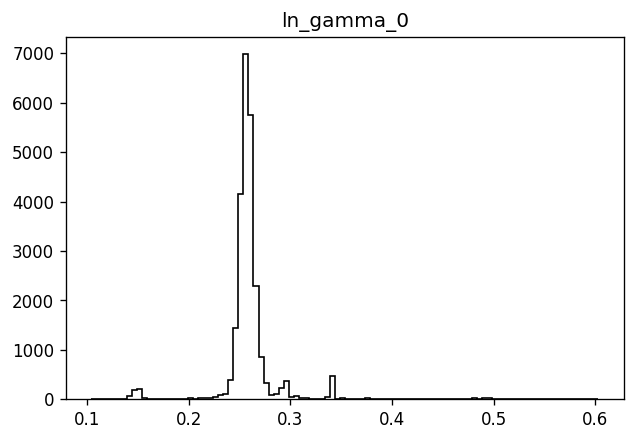

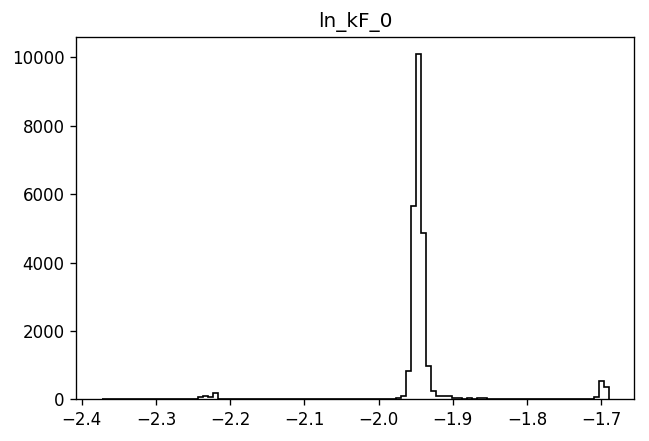

In [16]:
sampler.plot_histograms(cube=False)

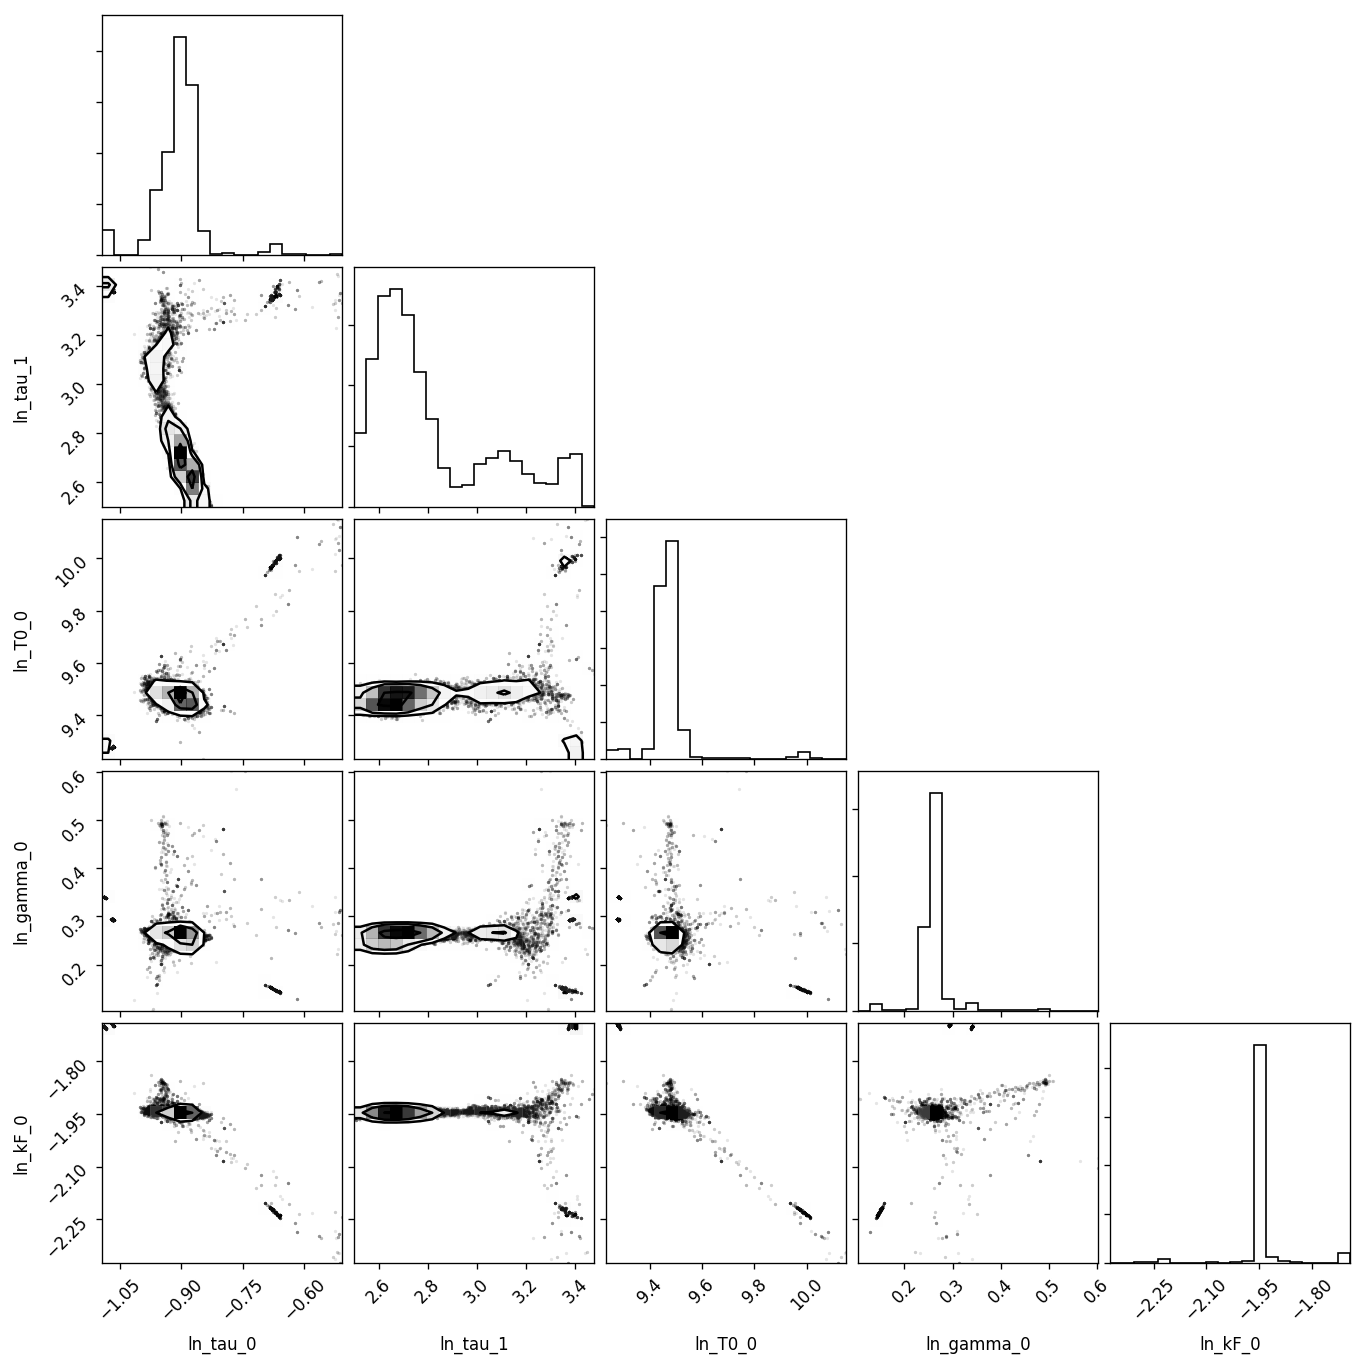

In [17]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [18]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

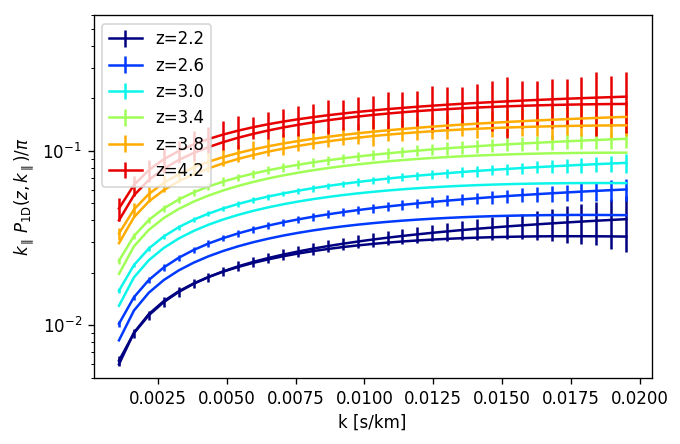

In [19]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=2)

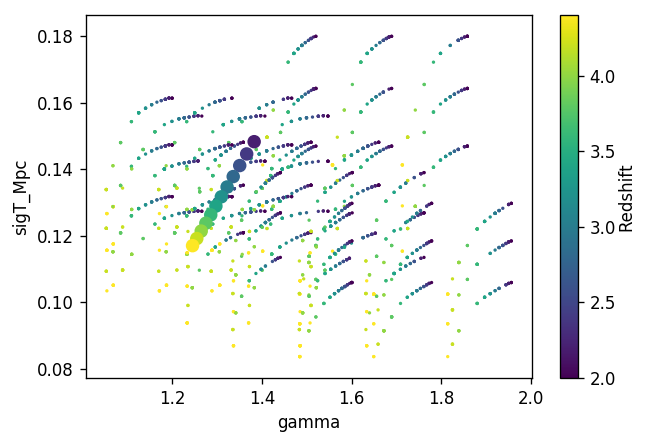

In [20]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc',values=best_fit)

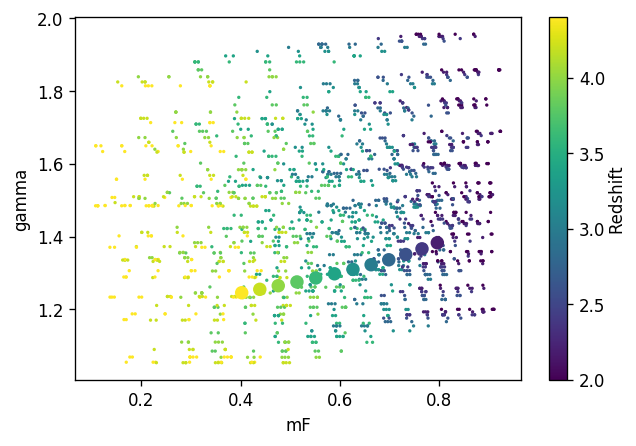

In [21]:
sampler.like.overplot_emulator_calls('mF','gamma',values=best_fit)

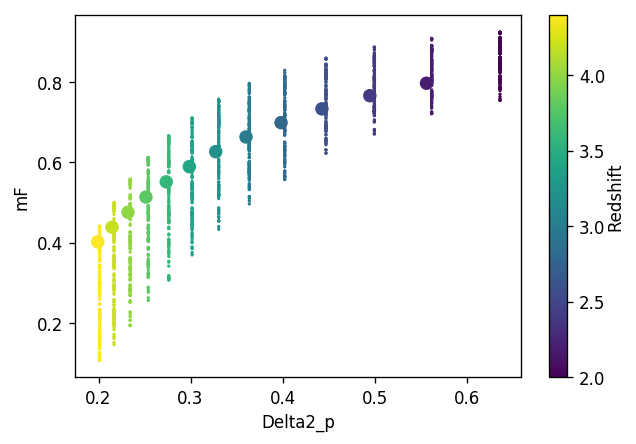

In [22]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=best_fit)

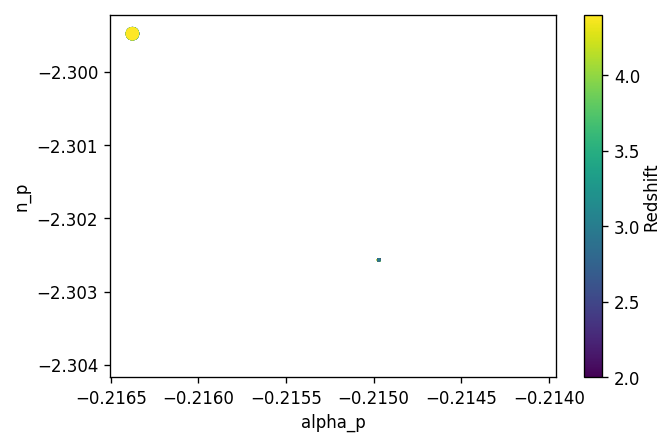

In [23]:
sampler.like.overplot_emulator_calls('alpha_p','n_p',values=best_fit)

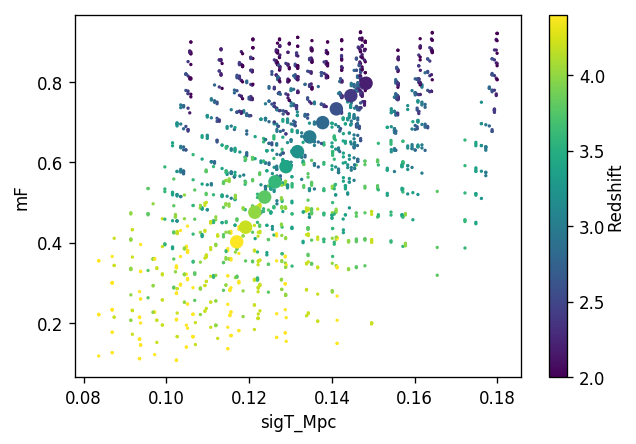

In [24]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF',values=best_fit)

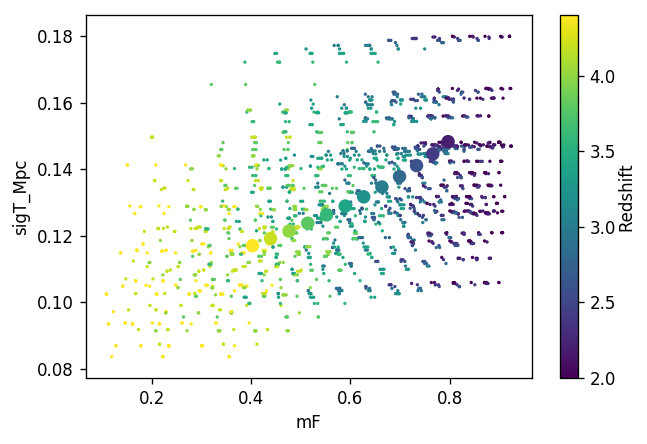

In [25]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc',values=best_fit)

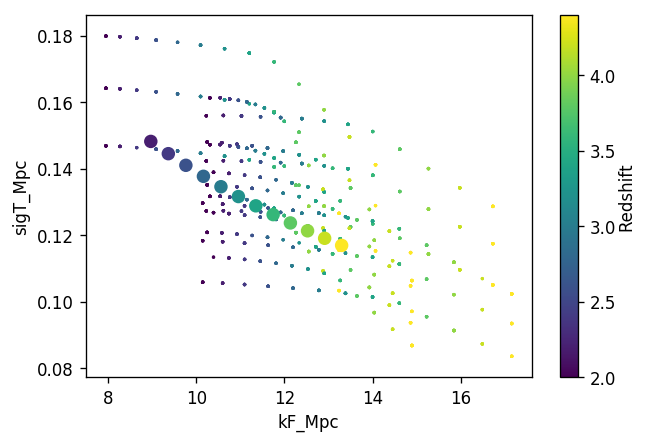

In [26]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc',values=best_fit)

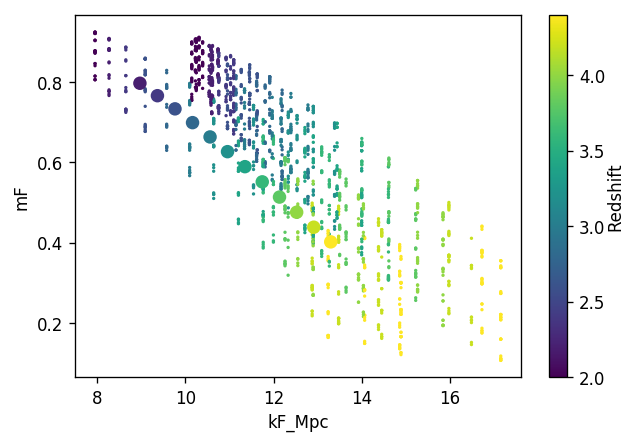

In [27]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF',values=best_fit)

### Write chain to file for later use

In [28]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [29]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


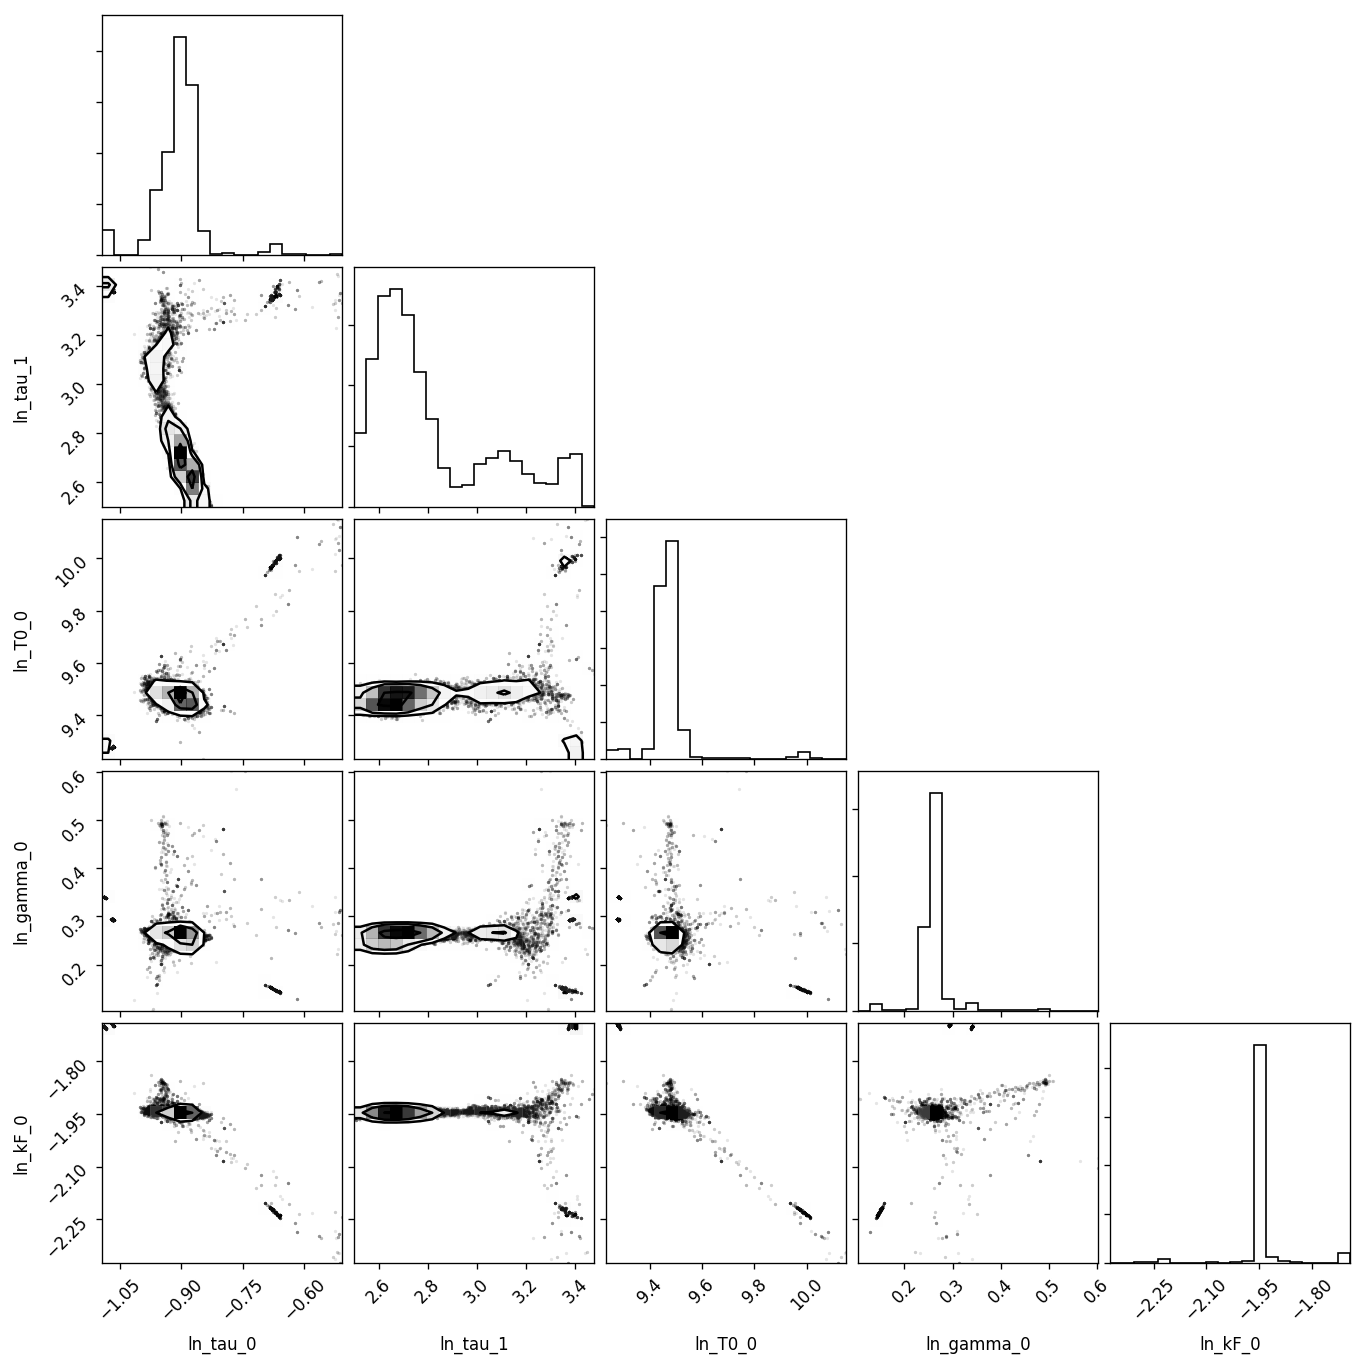

In [30]:
new_sampler.plot_corner(cube=False)

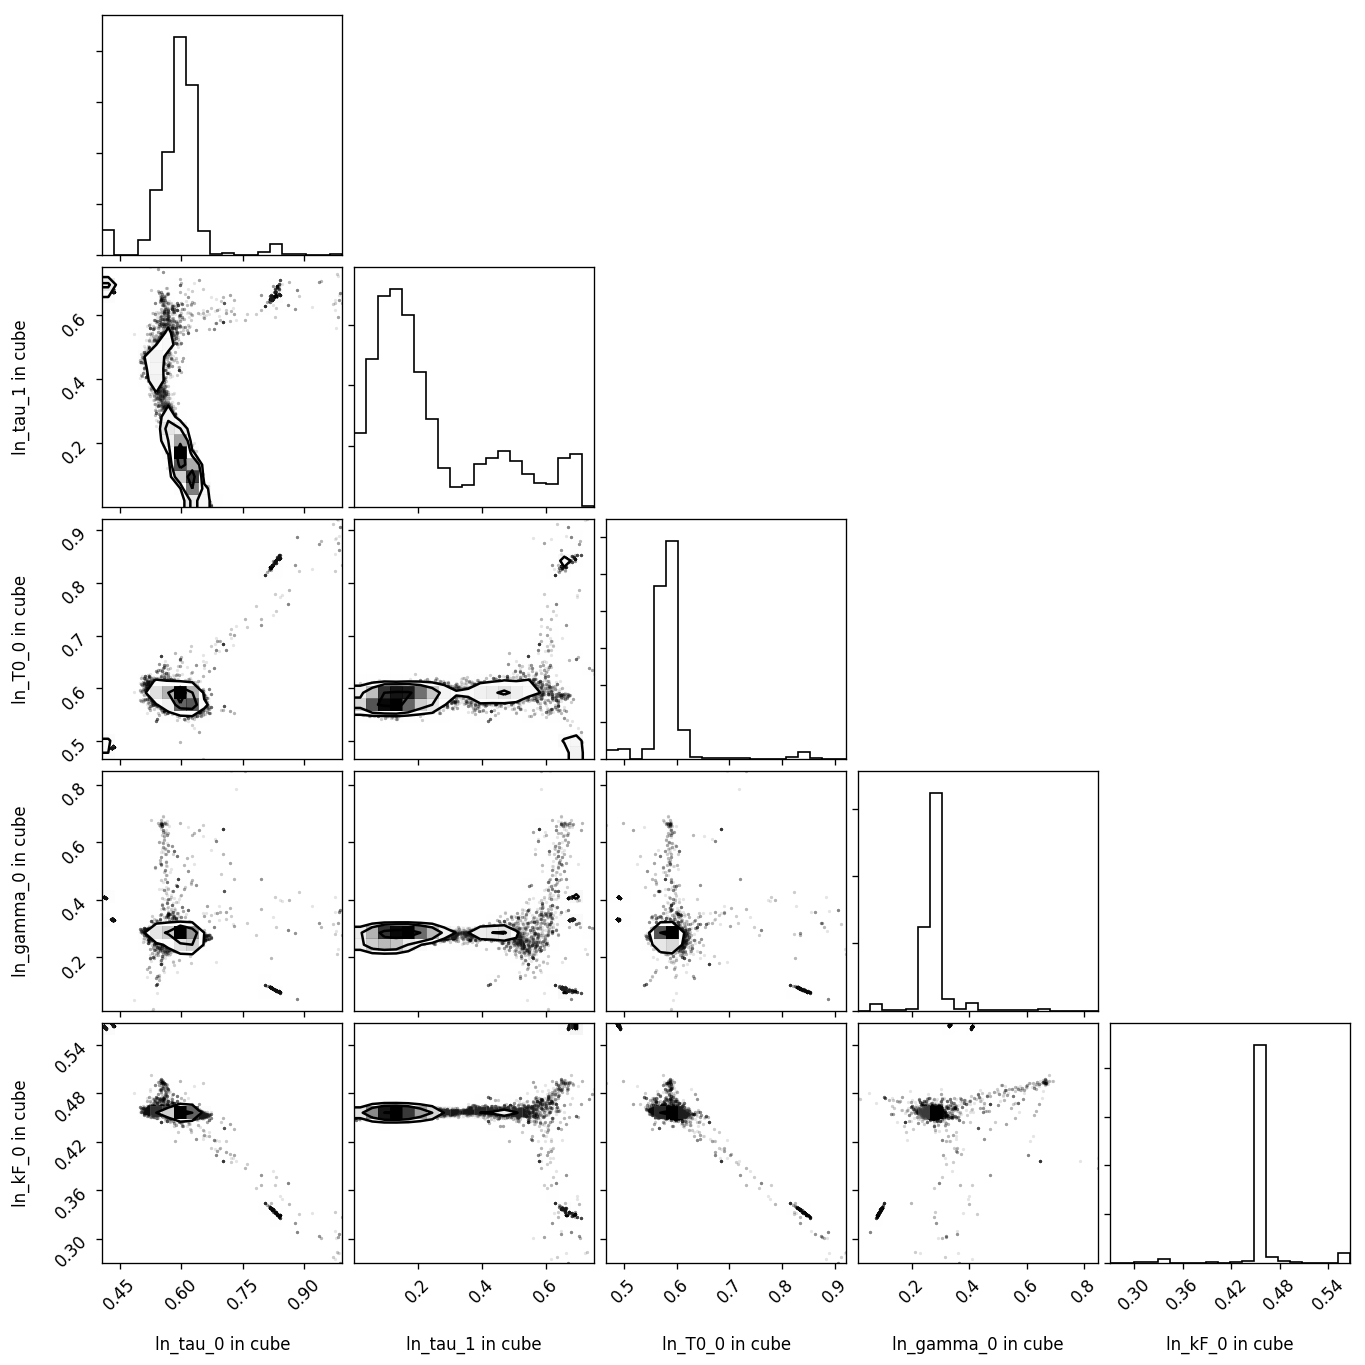

In [31]:
new_sampler.plot_corner(cube=True)

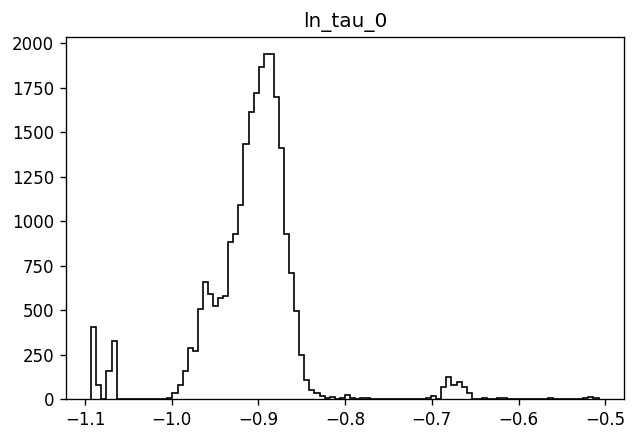

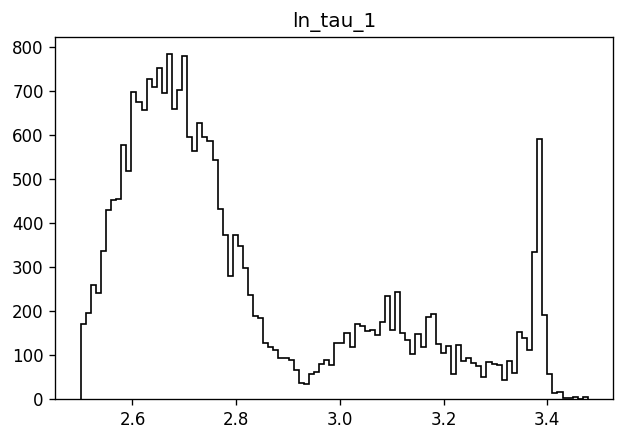

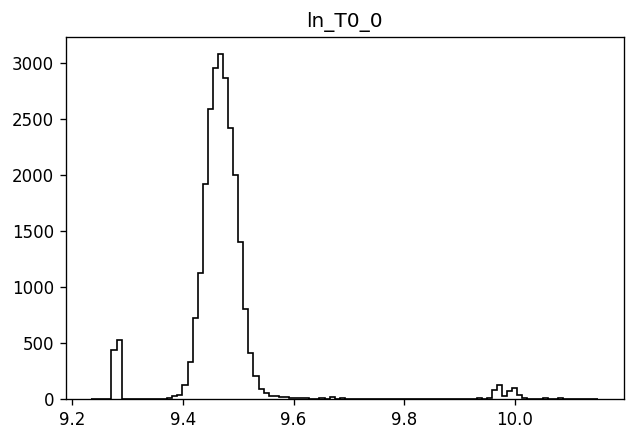

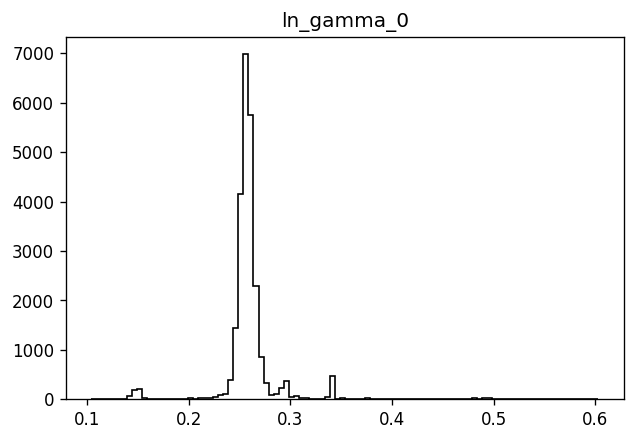

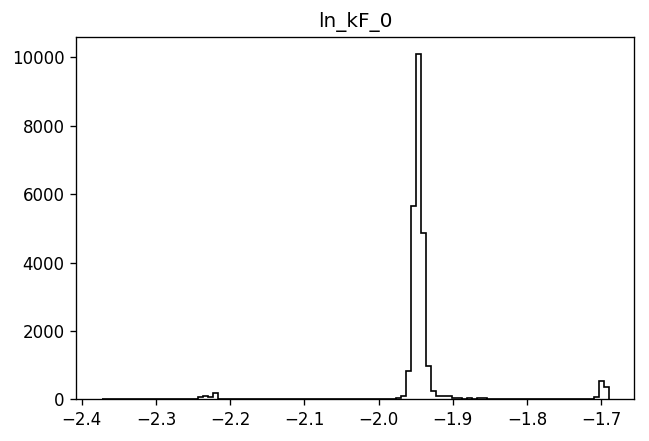

In [32]:
new_sampler.plot_histograms(cube=False)